In [1]:
import os
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews\\notebooks'

In [2]:
os.chdir("..")
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews'

In [3]:
from src.components.data_ingestion import DataIngestion
from src.components.data_transformation import DataTransformation

In [4]:
data_ingest = DataIngestion()
tr_D, ts_D = data_ingest.initate_data_ingestion()
data_trans = DataTransformation()
train_data, test_data = data_trans.initiate_data_transformation(tr_D, ts_D)

[2024-12-22 16:10:05,295, data_ingestion, INFO, Initiating data ingestion ]
[2024-12-22 16:10:05,296, data_ingestion, INFO, Establising Connection With SQL Database ]
[2024-12-22 16:10:05,298, data_ingestion, INFO, Successfully connected to the SQLite database. ]
[2024-12-22 16:10:05,299, data_ingestion, INFO, Reading New_Delhi_Reviews table  ]
[2024-12-22 16:10:05,683, data_ingestion, INFO, Successfully read the New_Delhi_Reviews as pandas dataframe ]
[2024-12-22 16:10:07,430, data_ingestion, INFO, succesfully ingested the raw data as a csv file into artifacts\raw_data.csv ]
[2024-12-22 16:10:07,432, data_ingestion, INFO, Initiating train test split ]
[2024-12-22 16:10:08,906, data_ingestion, INFO, train and test data split successful and stored respectively as csv files at artifacts\train_data.csv, artifacts\test_data.csv ]
[2024-12-22 16:10:08,933, data_transformation, INFO, Initiating the DataTransformation ]
[2024-12-22 16:10:08,935, data_transformation, INFO, Initiatig data trans

In [6]:
import umap
from sklearn.cluster import DBSCAN

reducer_cosine = umap.UMAP(n_neighbors = 100, min_dist = 0.5, metric='cosine', random_state=42)
low_dim_embeddings_cosine = reducer_cosine.fit_transform(train_data)

c:\Users\karthikeya\New_Delhi_Reviews\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\karthikeya\New_Delhi_Reviews\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\karthikeya\New_Delhi_Reviews\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


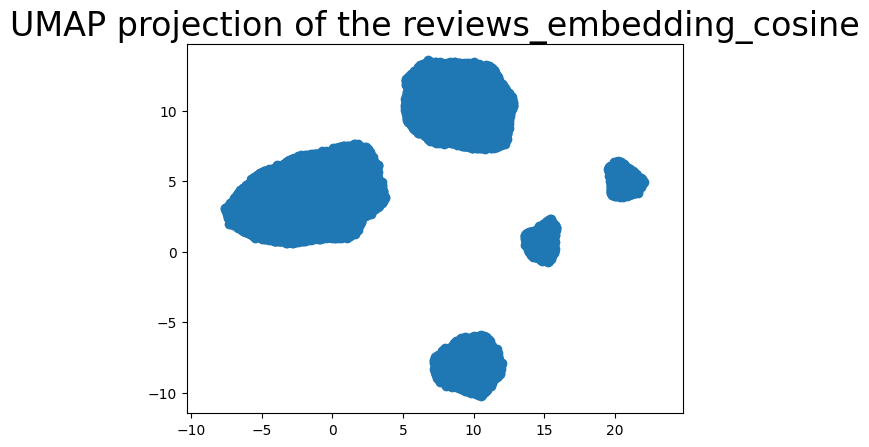

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(
    low_dim_embeddings_cosine[:, 0],
    low_dim_embeddings_cosine[:, 1],
   )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the reviews_embedding_cosine', fontsize=24);

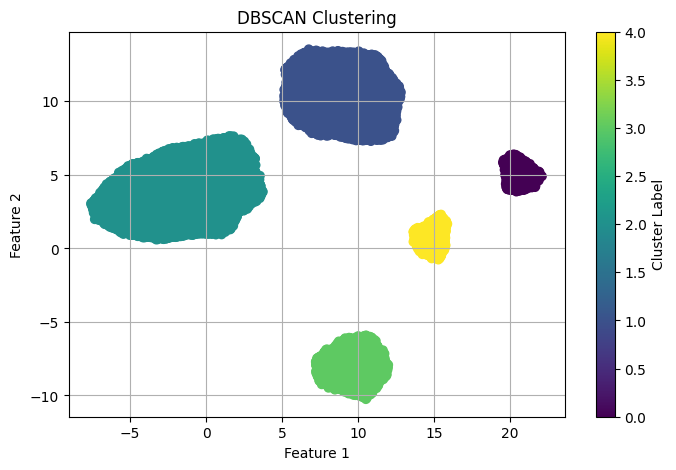

In [40]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=100)  # `eps` is the neighborhood size, `min_samples` is the minimum points to form a cluster
dbscan_labels = dbscan.fit_predict(low_dim_embeddings_cosine)

# 3. Visualize the results
plt.figure(figsize=(8, 5))

# Plot points with different colors based on their cluster label
plt.scatter(low_dim_embeddings_cosine[:, 0], low_dim_embeddings_cosine[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [45]:
sil_score = silhouette_score(low_dim_embeddings_cosine, dbscan_labels)

print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.7370256781578064


In [53]:
import pandas as pd
pd.Series(dbscan_labels).nunique()

5

In [5]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass

import pandas as pd
import numpy as np
import joblib as jl

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
import umap

from src.logger import logger
from src.components.data_transformation import DataTransformationConfig


In [6]:
class Reduce_Dimesionality(TransformerMixin, BaseEstimator):

    def __init__ (self):

        logger.info(f"Initiating the UMAP model for dimensionality reduction")
        logger.info(f"The n_neighbours =100, min_dist =0.5, metric=cosine")

        try:
            self.reducer = umap.UMAP(n_neighbors = 100, min_dist = 0.5, metric='cosine', n_jobs=-1, random_state=42, )
            pass
        except Exception as e:
            logger.info(f"Error initializing the UMAP: {e}")
            raise e
        

    def fit(self, X, y=None):

        try:
            logger.info(f"Fitting the UMAP to the given data")
            X_ = self.reducer.fit(X)
            return X_
        
        except Exception as e:
            logger.info(f"Error fitting the data with UMP : {e}")
            raise e
    


    def transform(self, X, y=None):
        try:
            logger.info(f"Transforming the given data using fitted UMAP model")
            X_ = self.reducer.transform(X)
            logger.info(f"Output shape after UMAP transform: {X_.shape}")
            return X_  
        except Exception as e:
            logger.error(f"Error transforming the data using the UMAP model: {e}")
            raise e


In [7]:
class ClusterData(TransformerMixin, BaseEstimator):
    def __init__(self):
        logger.info(f"Initializing the DBSCAN clustering model")
        try:
            self.dbscan = DBSCAN(eps=0.6, min_samples=100, n_jobs=-1)
            pass
        except Exception as e:
            logger.info(f"Error initializing the DBSCAN clustering model: {e}")
            raise e

    def fit(self, X, y=None):
        try:
            logger.info(f"Fitting the data to the DBSCAN cluster model")
            self.dbscan.fit(X)
            return self
        except Exception as e:
            logger.info(f"Error in fitting the data to the DBSCAN cluster model: {e}")
            raise e

    def transform(self, X, y=None):
        try:
            logger.info(f"Transforming the data using the DBSCAN clustering model")
            if X.ndim == 1:
                X = X.reshape(-1, 1)  # Ensure input is 2D
            labels = self.dbscan.fit_predict(X)
            logger.info(f"Successfully assigned clusters using DBSCAN")
            return labels.reshape(-1, 1)  # Ensure output is a 2D array
        except Exception as e:
            logger.info(f"Error in transforming the data with the DBSCAN model: {e}")
            raise e



In [8]:
@dataclass
class ModellingConfig:
    model_object : str = os.path.join('artifacts','cluster_model.joblib')

In [11]:
class Cluster_Modelling:

    def __init__(self):
        self.data_trans_config = DataTransformationConfig()
        self.model_config = ModellingConfig()
        pass

    def get_cluster_model(self):

        clustering_pipeline = Pipeline(
            [
            ('Dimesionality Reduction UMAP', Reduce_Dimesionality()),
            ('Cluster Data', ClusterData())

            ]
        )
        return clustering_pipeline
    
    def initiate_clustering(self):
        try:
            logger.info(f"Initialized clustering model")
            cluster = self.get_cluster_model()
            logger.info(f"Fitting the training data to the clustering model")
            tr_data = pd.read_csv(self.data_trans_config.transformed_train_file)
            train_cluster_labels = cluster.fit_transform(tr_data.values)
            logger.info(f"saving fitted cluster model at {self.model_config.model_object}")
            jl.dump(cluster, self.model_config.model_object)
            logger.info(f"Transforming the test data to")
            ts_data = pd.read_csv(self.data_trans_config.transformed_test_file)
            test_cluster_labels = cluster.transform(ts_data.values)
            logger.info(f" Returning cluster labes of train data and test resectively")
            return train_cluster_labels, test_cluster_labels
        except Exception as e:
            logger.info(f" Error in initiating the clustering pipeline : {e}")
            raise e

In [12]:
cluster = Cluster_Modelling()
train_cluster_lables, test_cluster_labels = cluster.initiate_clustering()

[2024-12-22 16:14:33,421, 2366838217, INFO, Initialized clustering model ]
[2024-12-22 16:14:33,423, 705939419, INFO, Initiating the UMAP model for dimensionality reduction ]
[2024-12-22 16:14:33,424, 705939419, INFO, The n_neighbours =100, min_dist =0.5, metric=cosine ]
[2024-12-22 16:14:33,425, 3653109047, INFO, Initializing the DBSCAN clustering model ]
[2024-12-22 16:14:33,428, 2366838217, INFO, Fitting the training data to the clustering model ]
[2024-12-22 16:14:33,873, 705939419, INFO, Fitting the UMAP to the given data ]
[2024-12-22 16:20:17,764, 3653109047, INFO, Fitting the data to the DBSCAN cluster model ]
[2024-12-22 16:20:20,629, 3653109047, INFO, Transforming the data using the DBSCAN clustering model ]
[2024-12-22 16:20:23,612, 3653109047, INFO, Successfully assigned clusters using DBSCAN ]
[2024-12-22 16:20:23,613, 2366838217, INFO, saving fitted cluster model at artifacts\cluster_model.joblib ]
[2024-12-22 16:20:57,848, 2366838217, INFO, Transforming the test data to 

In [13]:
train_cluster_lables

array([[0],
       [1],
       [1],
       ...,
       [2],
       [2],
       [1]], dtype=int64)

In [14]:
test_cluster_labels

array([[0],
       [1],
       [2],
       ...,
       [4],
       [0],
       [3]], dtype=int64)